In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
# from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')

2024-07-01 09:04:35.470948: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 09:04:35.470980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 09:04:35.471936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 09:04:35.477801: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)  # Thay đổi ở đây


In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [5]:
# Walk through each directory
dataset = "../../Smartbin/Dataset/Crawl_dataset/Data_real"
walk_through_dir(dataset)

There are 3 directories and 0 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real'.
There are 0 directories and 4061 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/UnRecycle'.
There are 0 directories and 8402 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Organic'.
There are 0 directories and 7552 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Recycle'.


In [6]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [7]:
# # Display 16 picture of the dataset with their labels
# random_index = np.random.randint(0, len(image_df), 16)
# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
#     ax.set_title(image_df.Label[random_index[i]])
# plt.tight_layout()
# plt.show()

In [8]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [9]:
train_generator = ImageDataGenerator(
    validation_split=0.2)

test_generator = ImageDataGenerator()

In [10]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 12292 validated image filenames belonging to 3 classes.
Found 3073 validated image filenames belonging to 3 classes.
Found 3842 validated image filenames belonging to 3 classes.


In [11]:
from keras.layers import BatchNormalization, MaxPooling2D, Flatten, Dense
model = models.Sequential()
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(224, 224, 3))),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2, 2)),
model.add(Conv2D(64, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Conv2D(128, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Conv2D(256, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Conv2D(512, (3,3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPooling2D(2,2)),
model.add(Flatten()),
model.add(Dense(512, activation='relu')),
model.add(BatchNormalization()),
model.add(Dense(3, activation='softmax'))

2024-07-01 09:04:38.098714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 09:04:38.098989: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 09:04:38.163528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
checkpoint_path = "bags_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [14]:
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 50,
                               restore_best_weights = True)

In [15]:
history=model.fit(train_images,
                  steps_per_epoch=len(train_images),
                  validation_data=val_images,
                  validation_steps=len(val_images),
                  epochs=200,
                  callbacks=[
                  early_stopping,
                  create_tensorboard_callback("training_logs", "bag_classification"),
                  checkpoint_callback,
                  ])

Saving TensorBoard log files to: training_logs/bag_classification/20240701-090438
Epoch 1/200


2024-07-01 09:04:40.685460: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-01 09:04:40.961739: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 532.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-01 09:04:41.173634: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 532.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-01 09:04:41.997674: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 323.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there co

  9/385 [..............................] - ETA: 1:11 - loss: 2.1879 - accuracy: 0.5868

/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


385/385 [==============================] - 119s 285ms/step - loss: 0.7045 - accuracy: 0.7306 - val_loss: 0.6873 - val_accuracy: 0.7240
Epoch 2/200
385/385 [==============================] - 105s 273ms/step - loss: 0.4843 - accuracy: 0.8055 - val_loss: 0.6769 - val_accuracy: 0.7309
Epoch 3/200
385/385 [==============================] - 105s 273ms/step - loss: 0.3913 - accuracy: 0.8432 - val_loss: 1.1279 - val_accuracy: 0.6691
Epoch 4/200
385/385 [==============================] - 105s 274ms/step - loss: 0.3293 - accuracy: 0.8760 - val_loss: 0.6255 - val_accuracy: 0.7481
Epoch 5/200
385/385 [==============================] - 105s 272ms/step - loss: 0.2528 - accuracy: 0.9051 - val_loss: 0.5183 - val_accuracy: 0.8109
Epoch 6/200
385/385 [==============================] - 104s 271ms/step - loss: 0.2153 - accuracy: 0.9212 - val_loss: 0.4483 - val_accuracy: 0.8366
Epoch 7/200
385/385 [==============================] - 109s 284ms/step - loss: 0.1639 - accuracy: 0.9407 - val_loss: 1.0081 - val_

In [21]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


    Test Loss: 0.38189
Test Accuracy: 89.82%


In [17]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

121/121 [==============================] - 25s 204ms/step
The first 5 predictions: ['Organic', 'Organic', 'Recycle', 'Organic', 'UnRecycle']


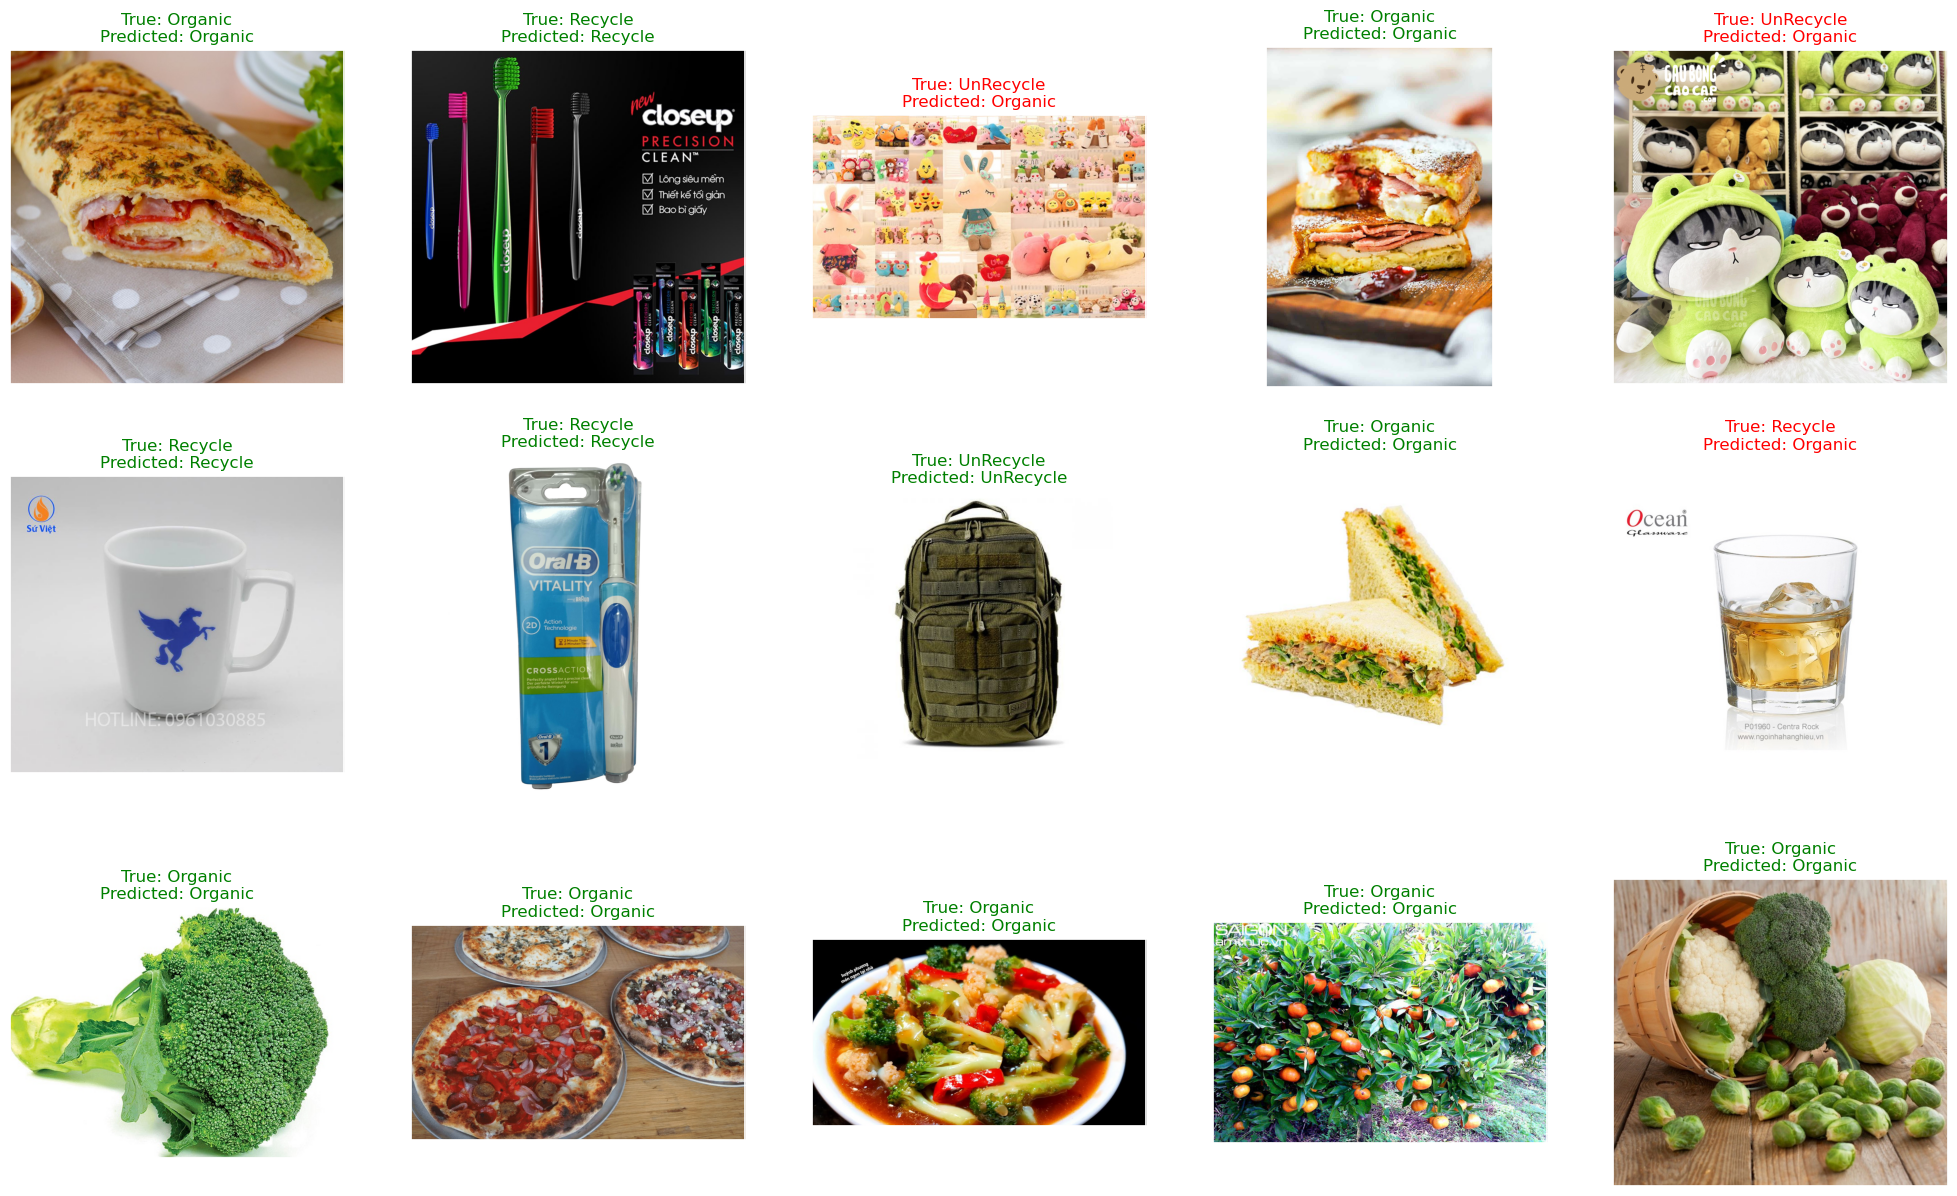

<Figure size 640x480 with 0 Axes>

In [18]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [19]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     Organic       0.91      0.94      0.92      1607
     Recycle       0.90      0.88      0.89      1457
   UnRecycle       0.88      0.84      0.86       778

    accuracy                           0.90      3842
   macro avg       0.90      0.89      0.89      3842
weighted avg       0.90      0.90      0.90      3842



In [22]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Organic,0.906587,0.942128,0.924016,1607.00000
Recycle,0.895804,0.879204,0.887426,1457.00000
UnRecycle,0.884097,0.843188,0.863158,778.00000
accuracy,0.898230,0.898230,0.898230,0.89823
macro avg,0.895496,0.888173,0.891533,3842.00000
weighted avg,0.897944,0.898230,0.897816,3842.00000
